In [46]:
import numpy as np
import os
import tensorflow as tf
import tifffile as tiff
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
    BatchNormalization, concatenate, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, classification_report, cohen_kappa_score, confusion_matrix
import seaborn as sns

In [13]:
from sklearn.model_selection import train_test_split

In [35]:
# data_dir = 'species_view_as_windows'
data_dir = 'species16'

In [8]:
def read_data(directory):
    X = []
    y = []
    for species in os.listdir(directory):
        if not species.startswith('.'):
            print(species)
            for i in os.listdir(directory + '/' + species):
                if not i.startswith('.'):
                    f = os.path.join(directory, species, i)
                    img = tiff.imread(f)
                    b0 = img[0]
                    b1 = img[1]
                    b2 = img[2]
                    b3 = img[3]
                    arr = np.stack((b0, b1, b2, b3), axis=2)
                    label = species
                    X.append(arr)
                    y.append(label)
    X = np.array(X)
    y = np.array(y)
    print(X.shape, y.shape)
    return X, y

X, y = read_data(data_dir)

ashe
southern
elm
pecan
hackberry
escarpment
crape
(37458, 8, 8, 4) (37458,)


In [36]:
X, y = read_data(data_dir)

ashe
southern
elm
pecan
hackberry
escarpment
crape
(10083, 16, 16, 4) (10083,)


In [37]:
y

array(['ashe', 'ashe', 'ashe', ..., 'crape', 'crape', 'crape'],
      dtype='<U10')

In [38]:
species_dict = {'pecan': 0,
                'elm': 1,
                'southern': 2,
                'escarpment': 3,
                'crape': 4,
                'hackberry': 5,
                'ashe': 6}
y = np.vectorize(species_dict.get)(y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)
print("X_train shape : ",X_train.shape)
print("y_train shape : ",y_train.shape)
print("X_test shape : ",X_test.shape)
print("y_test shape : ",y_test.shape)

X_train shape :  (29966, 8, 8, 4)
y_train shape :  (29966,)
X_test shape :  (7492, 8, 8, 4)
y_test shape :  (7492,)


In [39]:
# 16 x 16
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=42)
print("X_train shape : ",X_train.shape)
print("y_train shape : ",y_train.shape)
print("X_test shape : ",X_test.shape)
print("y_test shape : ",y_test.shape)

X_train shape :  (8066, 16, 16, 4)
y_train shape :  (8066,)
X_test shape :  (2017, 16, 16, 4)
y_test shape :  (2017,)


In [53]:
Counter(y_train)

Counter({0: 2180, 1: 1804, 2: 1741, 5: 406, 3: 1175, 4: 514, 6: 246})

In [61]:
train_rows=len(X_train)
X_train = X_train.reshape(train_rows,-1)
X_train.shape

sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
X_train = X_train.reshape(-1,16,16,4)
X_train.shape

(15260, 16, 16, 4)

In [64]:
print("X_train shape : ",X_train.shape)
print("y_train shape : ",y_train.shape)
print("X_test shape : ",X_test.shape)
print("y_test shape : ",y_test.shape)

X_train shape :  (15260, 16, 16, 4)
y_train shape :  (15260,)
X_test shape :  (2017, 16, 16, 4)
y_test shape :  (2017,)


In [62]:
Counter(y_train)

Counter({0: 2180, 1: 2180, 2: 2180, 5: 2180, 3: 2180, 4: 2180, 6: 2180})

In [ ]:
# data preprocess
batch_size = 128

training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)

## DenseNet

In [65]:
tile_size = 16

In [66]:
def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters

In [67]:
def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(tile_size, tile_size, 4))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)


In [68]:
dense_block_size = 3
layers_in_block = 4

growth_rate = 12
classes = 7
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 16, 16, 4)]  0           []                               
                                                                                                  
 conv2d_45 (Conv2D)             (None, 16, 16, 24)   864         ['input_4[0][0]']                
                                                                                                  
 activation_48 (Activation)     (None, 16, 16, 24)   0           ['conv2d_45[0][0]']              
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 8, 8, 24)    0           ['activation_48[0][0]']          
                                                                                            

                                                                                                  
 activation_55 (Activation)     (None, 4, 4, 84)     0           ['batch_normalization_55[0][0]'] 
                                                                                                  
 conv2d_52 (Conv2D)             (None, 4, 4, 12)     9072        ['activation_55[0][0]']          
                                                                                                  
 dropout_41 (Dropout)           (None, 4, 4, 12)     0           ['conv2d_52[0][0]']              
                                                                                                  
 concatenate_41 (Concatenate)   (None, 4, 4, 96)     0           ['concatenate_40[0][0]',         
                                                                  'dropout_41[0][0]']             
                                                                                                  
 batch_nor

 activation_62 (Activation)     (None, 2, 2, 156)    0           ['batch_normalization_62[0][0]'] 
                                                                                                  
 conv2d_59 (Conv2D)             (None, 2, 2, 12)     16848       ['activation_62[0][0]']          
                                                                                                  
 dropout_47 (Dropout)           (None, 2, 2, 12)     0           ['conv2d_59[0][0]']              
                                                                                                  
 concatenate_47 (Concatenate)   (None, 2, 2, 168)    0           ['concatenate_46[0][0]',         
                                                                  'dropout_47[0][0]']             
                                                                                                  
 batch_normalization_63 (BatchN  (None, 2, 2, 168)   672         ['concatenate_47[0][0]']         
 ormalizat

In [26]:
# 8x8 training
batch_size = 256
# img_height = 8
# img_width = 8
# batch_size = 32
epochs = 50

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size, shuffle=True,validation_data=(X_test, y_test))

Epoch 1/50
118/118 [==============================] - 9s 63ms/step - loss: 1.7128 - accuracy: 0.3182 - val_loss: 2.2155 - val_accuracy: 0.2270
Epoch 2/50
118/118 [==============================] - 7s 63ms/step - loss: 1.5688 - accuracy: 0.4006 - val_loss: 2.1574 - val_accuracy: 0.2090
Epoch 3/50
118/118 [==============================] - 8s 64ms/step - loss: 1.5157 - accuracy: 0.4266 - val_loss: 1.5860 - val_accuracy: 0.3887
Epoch 4/50
118/118 [==============================] - 7s 62ms/step - loss: 1.4831 - accuracy: 0.4377 - val_loss: 1.4814 - val_accuracy: 0.4375
Epoch 5/50
118/118 [==============================] - 8s 69ms/step - loss: 1.4581 - accuracy: 0.4488 - val_loss: 1.5019 - val_accuracy: 0.4289
Epoch 6/50
118/118 [==============================] - 8s 66ms/step - loss: 1.4370 - accuracy: 0.4577 - val_loss: 1.4577 - val_accuracy: 0.4443
Epoch 7/50
118/118 [==============================] - 8s 65ms/step - loss: 1.4210 - accuracy: 0.4613 - val_loss: 1.8104 - val_accuracy: 0.3388

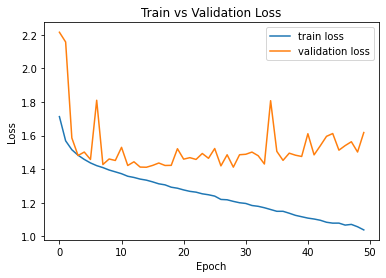

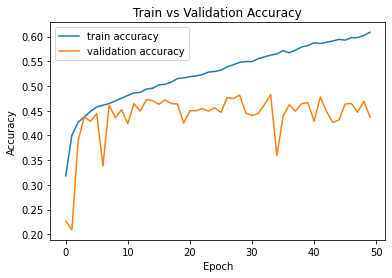

In [30]:
plot_loss_acc(history, epochs)


=======================Evaluation on Train Set=======================

Accuracy on train set: 0.606

========================Evaluation on Test Set=======================

Accuracy on test set: 0.437
Cohen’s kappa coefficient on test set: 0.287

==================Classification Report on Test Set==================

                     precision    recall  f1-score   support

              pecan       0.53      0.51      0.52      2035
          elm cedar       0.47      0.61      0.53      1661
  southern live oak       0.47      0.44      0.46      1623
escarpment live oak       0.30      0.38      0.33      1105
       crape myrtle       0.25      0.09      0.13       467
          hackberry       0.15      0.05      0.08       372
       ashe juniper       0.31      0.12      0.17       229

           accuracy                           0.44      7492
          macro avg       0.35      0.31      0.32      7492
       weighted avg       0.42      0.44      0.42      7492



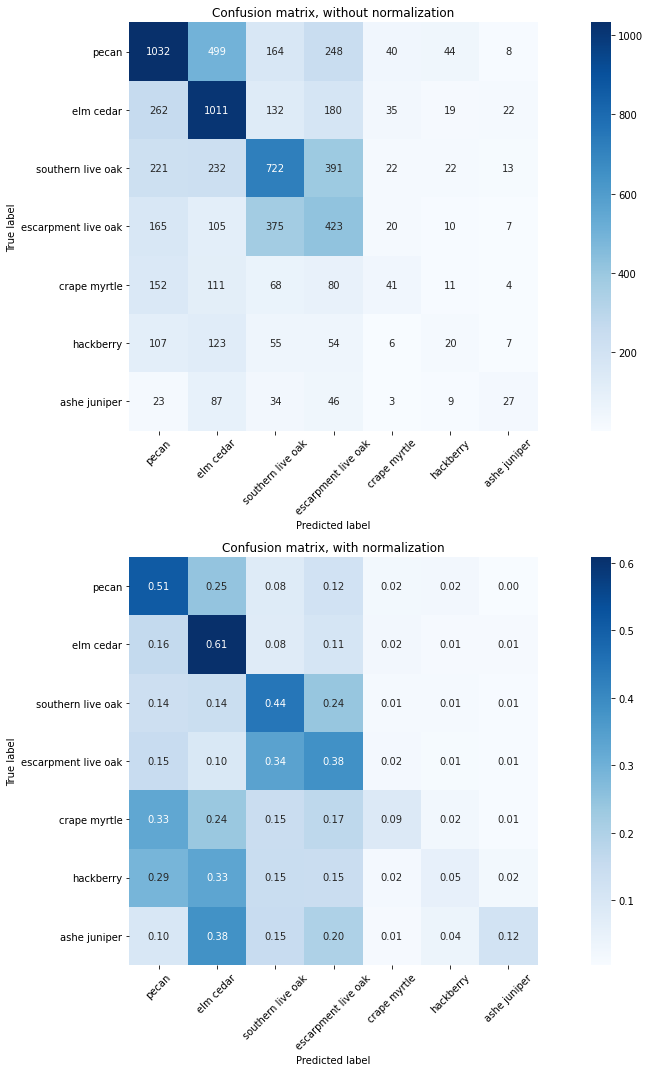

In [33]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_train_pred_max = np.argmax(y_train_pred, axis = 1)
y_test_pred_max = np.argmax(y_test_pred, axis = 1)

metrics_evaluation(y_train, y_train_pred_max, y_test, y_test_pred_max, tree_species)

In [69]:
# 16x16 training
batch_size = 256
epochs = 50
#learning_rate
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
history=model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size, shuffle=True,validation_data=(X_test, y_test))

Epoch 1/50


/Users/kennywu/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


60/60 [==============================] - 15s 223ms/step - loss: 1.7104 - accuracy: 0.3280 - val_loss: 3.7490 - val_accuracy: 0.1715
Epoch 2/50
60/60 [==============================] - 13s 214ms/step - loss: 1.4713 - accuracy: 0.4293 - val_loss: 2.4576 - val_accuracy: 0.2176
Epoch 3/50
60/60 [==============================] - 13s 214ms/step - loss: 1.3584 - accuracy: 0.4810 - val_loss: 2.6131 - val_accuracy: 0.1998
Epoch 4/50
60/60 [==============================] - 13s 219ms/step - loss: 1.2469 - accuracy: 0.5254 - val_loss: 2.4703 - val_accuracy: 0.2152
Epoch 5/50
60/60 [==============================] - 13s 211ms/step - loss: 1.1586 - accuracy: 0.5678 - val_loss: 1.8492 - val_accuracy: 0.3198
Epoch 6/50
60/60 [==============================] - 12s 208ms/step - loss: 1.0813 - accuracy: 0.5910 - val_loss: 1.7916 - val_accuracy: 0.3079
Epoch 7/50
60/60 [==============================] - 13s 213ms/step - loss: 1.0135 - accuracy: 0.6244 - val_loss: 2.1779 - val_accuracy: 0.2479
Epoch 8/50

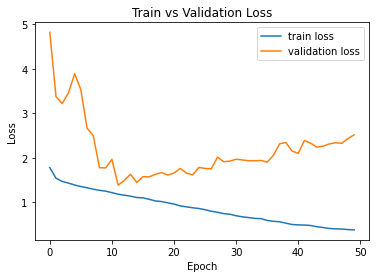

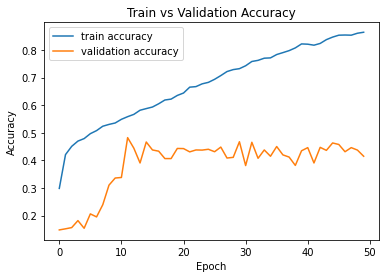


=======================Evaluation on Train Set=======================

Accuracy on train set: 0.837

========================Evaluation on Test Set=======================

Accuracy on test set: 0.415
Cohen’s kappa coefficient on test set: 0.256

==================Classification Report on Test Set==================

                     precision    recall  f1-score   support

              pecan       0.46      0.74      0.57       545
          elm cedar       0.55      0.26      0.35       451
  southern live oak       0.42      0.45      0.44       436
escarpment live oak       0.36      0.26      0.30       294
       crape myrtle       0.19      0.20      0.19       128
          hackberry       0.09      0.04      0.05       102
       ashe juniper       0.20      0.21      0.20        61

           accuracy                           0.41      2017
          macro avg       0.32      0.31      0.30      2017
       weighted avg       0.41      0.41      0.39      2017



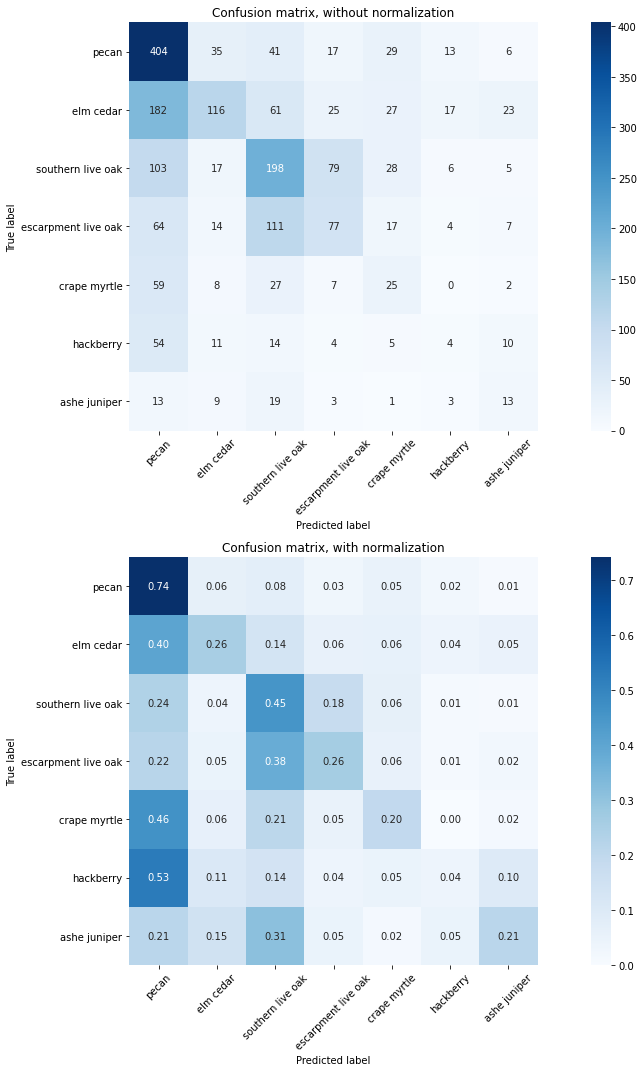

In [45]:
# 16x16
plot_loss_acc(history, epochs)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_train_pred_max = np.argmax(y_train_pred, axis = 1)
y_test_pred_max = np.argmax(y_test_pred, axis = 1)

metrics_evaluation(y_train, y_train_pred_max, y_test, y_test_pred_max, tree_species)

In [27]:
def plot_loss_acc(model_hist, epochs_num):
    loss=model_hist.history['loss']
    val_loss=model_hist.history['val_loss']
    epochs = list(range(epochs_num))
    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train vs Validation Loss')
    plt.show()
    
    acc=model_hist.history['accuracy']
    val_acc=model_hist.history['val_accuracy']
    plt.plot(epochs, acc, label='train accuracy')
    plt.plot(epochs, val_acc, label='validation accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Accuracy')
    plt.show()

In [28]:
# 7 tree species to classify
tree_species = ['pecan', 'elm cedar', 'southern live oak', 'escarpment live oak', \
                                   'crape myrtle', 'hackberry', 'ashe juniper']

# metrics to evaluate
# a) Accuracy on train and test set respectively
# b) Cohen Kappa's coefficient on test set
# c) Each species’s Precision, Recall, F1-score, Overall accuracy
# d) Confusion matrix
def metrics_evaluation(y_dev, y_dev_pred, y_test, y_test_pred, classes=tree_species):
    
    # a) Accuracy on train and test set respectively
    print('\n=======================Evaluation on Train Set=======================\n')
    print(f'Accuracy on train set: {accuracy_score(y_dev, y_dev_pred):.3f}')
    print('\n========================Evaluation on Test Set=======================\n')
    print(f'Accuracy on test set: {accuracy_score(y_test, y_test_pred):.3f}')
    
    # b) Cohen Kappa's coefficient on test set
    print(f'Cohen’s kappa coefficient on test set: {cohen_kappa_score(y_test, y_test_pred):.3f}')
    
    # c) Each species’s Precision, Recall, F1-score, Overall accuracy
    print('\n==================Classification Report on Test Set==================\n')
    print(classification_report(y_test, y_test_pred, target_names=tree_species, zero_division=0))
    
    # d) Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,15))
    
    sns.heatmap(cm, square=True, annot=True, cbar=True, cmap=plt.cm.Blues, fmt='.0f', ax=ax1)
    ax1.set_title('Confusion matrix, without normalization')
    ax1.set_xticklabels(classes, rotation=45)
    ax1.set_yticklabels(classes, rotation=0)
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')
    plt.tight_layout()
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, square=True, annot=True, cbar=True, cmap=plt.cm.Blues, fmt='.2f', ax=ax2)
    ax2.set_title('Confusion matrix, with normalization')
    ax2.set_xticklabels(classes, rotation=45)
    ax2.set_yticklabels(classes, rotation=0)
    ax2.set_ylabel('True label')
    ax2.set_xlabel('Predicted label')
    plt.tight_layout()